# Forêts aléatoires (random forests)

<img src="files/figures/RF.png" width="500px"/>

## Librairies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loader les data

In [2]:
data = pd.read_csv("./data/airfoil_self_noise.csv", sep='\t')

In [3]:
data.head(5)

,x0,x1,x2,x3,x4,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


Nous allons prédire la variable `y` en fonction des variables `x0`, `x1`, `x2`, `x3`, `x4`.

## Forêt aléatoire dans un contexte de régression

- Une **forêt aléatoire (random forest)** est un **modèle ensembliste** obtenu à partir de plusieurs **arbres de décision (decision trees)**.
- On utilise une technique de **bagging** améliorée pour agréger et décorréler les arbres de décision utilisés.
- La technique de décorrélation des arbres de décision a pour but de diminuer la variance du modèle final.

La classe `DecisionNode` ci-dessous représente un **noeud** d'un **arbre de décision**, ou encore, un **arbre de décision** en soi. 

*En effet, en programmation, un objet "noeud" qui pointe vers ses fils est une structure de données suffisante pour représenter un arbre binaire.*

- Un **noeud interne** représente un *split* de la forme $x_m \leq s$ (où $x_m$ est la $m$-ième composante de $\mathbf{x}$).<br>
Chaque noeud interne donc est associé à un `feature_index` $m$ et un `threshold` $s$.<br>
Un noeud interne est également associé à `var_red`: la réduction de variance engendrée par son split.


- Une **feuille** représente un sous-ensemble des data $R_k$ (*région*, *cellule de partition*).<br>
Chaque feuille est donc associée une `value`: la target moyenne des data dans $R_m$<br> 

$$\hat{y}_{R_k} = \frac{1}{|R_k|} \sum_{\{i : \mathbf{x_i} \in R_k\}} y_i$$

In [4]:
class DecisionNode():
    """
    Implements a decision node, or quivalently, a decision tree.
    
    As usual, a binary tree is identified with a root node contaning as chidren
    a left subtree and a right subtree.
    
    Here, an *internal node* represents a split of the form "x_m <= s",
    where m is the `feature_index` and s the `thresold` of the split.
    
    A *leaf node* represents a subset of the data (region, box, partition cell).
    It is associated with a `value`: the average target for the data in this region.
    """
    
    def __init__(self, feature_index=None, threshold=None, 
                 left=None, right=None, var_red=None, value=None):
        """
        Constructor.
        
        Parameters
        ----------
        feature_index : int
            index m of variable x_m for the node split (x_m <= s).
        threshold : Union[int, float]
            threshold s for the node split (x_m <= s).
        left : Union[DecisionNode, None]
            Left child of the node
        right : Union[DecisionNode, None]
            Right child of the node
        var_red : float
            variance reduction induced by the node split (x_m <= s).
        value : Union[float, None]
            if the node is a leaf, then value of this leaf.
        """

        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.var_red = var_red

        # for leaf node
        self.value = value
        
        # children
        self.left = left
        self.right = right
        
        
    def print_tree(self, tab=0):
        """Prints the node (i.e., the tree)."""
        
        if self.left is None and self.right is None: # leaf
            
            print("\t"*(tab), f"{self.value:.2f}")
            
        else:                                        # internal node
            self.left.print_tree(tab+1)
            print("\t"*(tab), f"X_{self.feature_index} < {self.threshold:.2f}")
            self.right.print_tree(tab+1)

La classe `DecisionTreeRegressor` ci-dessous représente un **arbre de décision** dans un contexte de régression.

In [5]:
class DecisionTreeRegressor():
    """
    Implements a decision tree for regression.
    """
    
    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor.
        
        Parameters
        ----------
        min_samples : int
            Minimal number of data necessary to envision a split.
            Otherwise, the node is a leaf (subset of data).
        max_depth : int
            Maximal depth of the tree.
            When max_depth is reached, no further split is performed.
        """
        
        # the root will become the decision tree
        self.root = None
        
        # stopping conditions
        self.min_samples = min_samples
        self.max_depth = max_depth
        
    
    def split_data(self, dataset, split):
        """
        Splits dataset according to a given split of the form x_m <= s.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset to be split
        split : tuple
            A split "x_m <= s" is represented by the tuple (m, s),
            where m is the feature_index and s the threshold.
        
        Returns
        -------
        dataset_left, dataset_right : tuple[ndarray, ndarray]
            dataset_left: data satisfying the condition x_m <= s.
            dataset_right: data satisfying the scondition x_m > s.
        """
        
        feature_index, threshold = split
        mask = dataset[:, feature_index] <= threshold
        dataset_left = dataset[mask, :]
        dataset_right = dataset[np.logical_not(mask), :]
        
        return dataset_left, dataset_right
    
    
    def variance_reduction(self, dataset, dataset_left, dataset_right):
        """
        Computes the variance reduction of the targets induced by a split.
        
        Suppose that a split of a dataset has induces the 2 datasets:
        dataset_left and dataset_right (cf. method split_data).
        This function computes the variance $var_1$ of the y's of dataset as well as
        the weighted variance $var_2$ of the y's of left_dataset and right_dataset.
        The variance reduction is then given by $var_1 - var_2$.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset before split.
        dataset_left : ndarray
            First dataset induced by the split.
        dataset_right : ndarray
            Second dataset induced by the split.
        
        Returns
        -------
        var_reduction : float
            variance reduction induced by the split.
        """
        
        y = dataset[:, -1]
        y_l = dataset_left[:, -1]
        y_r = dataset_right[:, -1]
        
        w_l = len(y_l) / len(y)
        w_r = len(y_r) / len(y)
        
        var_reduction = np.var(y) - ( w_l * np.var(y_l) + w_r * np.var(y_r) )
        
        return var_reduction

    
    def best_split(self, dataset):
        """
        Computes the best split for a dataset.
        
        For all feature $m$ and and all possible value $s$ of that feature,
        split the dataset according to the condition "x_m <= s" (self.split_data(...)).
        The split "x_m <= s" generates two datatsets: dataset_left and dataset_right.
        Compute the variance reduction associated to the three datasets (self.variance_reduction).
        Select the split associated with the largest variance reduction.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset before split.
        
        Returns
        -------
        best_split : dict
            dictionary to store the best split.
            The keys of the dictionare are: 
            "feature_index", "threshold", "dataset_left", "dataset_right", "var_red".
        """
        
        # dictionary to store the best split
        best_split = {}
        best_var_red = -float("inf")
        
        # loop over features
        nb_features = dataset.shape[1] - 1
        for m in range(nb_features):
            
            thresholds = dataset[:, m]
            thresholds = np.unique(thresholds)
            
            # loop over thresholds
            for s in thresholds:
                
                # datasets assoociated to split "x_m <= s"
                split = (m, s)
                dataset_left, dataset_right = self.split_data(dataset, split)
                
                # check if datasets are not empty
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    
                    # compute variance reduction
                    var_red = self.variance_reduction(dataset, dataset_left, dataset_right)
                    
                    # update the best split if needed
                    if var_red > best_var_red:
                        
                        best_split["feature_index"] = m
                        best_split["threshold"] = s
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_reduction"] = var_red
                        best_var_red = var_red
                        
        # return best split
        return best_split
    
    
    def leaf_value(self, region):
        """
        Compute the mean of targets of a non-splitable region. 
        Teh region is associated to a leaf node of the decision tree.
        
        Parameters
        ----------
        region : ndarray
            Non-splitable dataset that corresponds to a region oof the partition.
        
        Returns
        -------
        mean : float
            Mean of targets for the data in the region.
        """
        
        Y = region[:, -1]
        mean = np.mean(Y)
        
        return mean
    
    
    def build_tree(self, dataset, depth=0):
        """
        Builds the decision tree recursively.
        
        Parameters
        ----------
        dataset : ndarray
            Initial dataset to be split by the decision tree.
        depth : int
            Depth of the decision tree that has been built so far.
        
        Returns
        -------
        DecisionNode : DecisionNode
            The decision tree that represent the best successive splits
            for to the dataset.
        """
        
        num_samples = np.shape(dataset)[0]
                
        # compute decision node
        if num_samples >= self.min_samples and depth <= self.max_depth:
            
            # find the best split
            split = self.best_split(dataset)
            
            # check if variance reduction is positive
            if split["var_reduction"] >= 0:
                
                # recursive call left
                subtree_left = self.build_tree(split["dataset_left"], depth + 1)
                
                # recursive call right
                subtree_right = self.build_tree(split["dataset_right"], depth + 1)
                
                return DecisionNode(split["feature_index"], split["threshold"], 
                                    subtree_left, subtree_right, split["var_reduction"])
            
        # compute leaf node
        else:
            
            value = self.leaf_value(dataset)
            
            return DecisionNode(value=value)
    
    
    def fit(self, X, y):
        """
        Fits the decision tree on the features X and targets y.
        
        Parameters
        ----------
        X : ndarray
            Feature columns of the dataset.
        y : ndarray
            Target column of the dataset.
        """
        
        dataset = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(dataset)
        
        
    def predict_single_point(self, x, tree):
        """        
        Predict the target y_hat associated to a point x.
        
        Parameters
        ----------
        x : ndarray
            Point x = (x_1,...,x_M) whose target is to be predicted.
            
        Returns
        -------
        y_hat : float
            Target associated to x.
        """
        
        if tree.value != None:
            
            return tree.value
        
        # x_m <= s
        if x[tree.feature_index] <= tree.threshold:
            
            return self.predict_single_point(x, tree.left)
        
        # x_m > s
        else:
            
            return self.predict_single_point(x, tree.right)
        
    
    def predict(self, X):
        """
        Predict the targets associated to a set of points.
        
        Parameters
        ----------
        X : ndarray
            Tensor of points X (dim N x M) whose targets are to be predicted.
            
        Returns
        -------
        predictions : ndarray
            Tensor of targets (dim N x 1) associated to X.
        """
        
        predictions = np.array([self.predict_single_point(x, self.root) for x in X])
        
        return predictions

La classe `RandomForest` ci-dessous représente une **forêt aléatoire** dans un contexte de régression.

In [6]:
class RandomForest():
    """
    Implements a random forest for regression.
    """
    
    def __init__(self, nb_trees=10, min_samples=2, max_depth=2):
        """
        Constructor.
        
        Parameters
        ----------
        nb_trees : int
            Number of decision trees in the random forest.
        min_samples : int
            When building a decision tree in the forest,
            minimal number of data necessary to envision a split.
            Otherwise, the node is a leaf (subset of data).
        max_depth : int
            When building a decision tree in the forest,
            maximal depth of the tree.
            When max_depth is reached, no further split is performed.
        """
        
        self.nb_trees = nb_trees
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.decision_trees = []
    
    
    def generate_sampled_dataset(self, X, y, n=None):
        """
        Generate a new "bootstrapped" dataset by drawing 
        n samples with replacemnt from the dataset (X, y).
        
        Parameters
        ----------
        n : int
            Size of the bootstrapped dataset
        X : ndarray
            Feature columns of the dataset.
        y : ndarray
            Target column of the dataset.
            
        Returns
        -------
        X_new : ndarray
            Bootstrapped tensor of features (n x nb_features).
        y_new : ndarray
            Bootstrapped tensor of targets (n x 1).
        """
        
        if n is None:
            n = X.shape[0]
        
        random_idx = np.random.randint(0, X.shape[0], n)
        random_idx = np.unique(random_idx)
        X_new = X[random_idx, :]
        y_new = y[random_idx, :]
        
        return X_new, y_new
        
        
    def fit(self, X, y):
        """
        Fits the random forest on the features X and targets y.
        The successive decision trees composing the forest are stored in the list self.decision_trees.
        
        Parameters
        ----------
        X : ndarray
            Feature columns of the dataset.
        y : ndarray
            Target column of the dataset.
        """
        
        n = X.shape[0]
        
        for b in range(self.nb_trees):
            
            X_new, y_new = self.generate_sampled_dataset(X, y, n)
            dt = DecisionTreeRegressor(self.min_samples, self.max_depth)
            dt.fit(X_new, y_new)
            self.decision_trees.append(dt)
    
    
    def predict(self, X):
        """
        Predict the targets associated to a set of points.
        
        Parameters
        ----------
        X : ndarray
            Tensor of points X whose targets are to be predicted.
            
        Returns
        -------
        predictions : ndarray
            Tensor of targets associated to X.
        """
        
        predictions = np.mean([dt.predict(X) for dt in self.decision_trees], axis=0)
        
        return predictions

### Exercice 1

Complétez la méthode `generate_sampled_dataset(...)` de la classe `RandomForest` qui, étant donné un dataset `X, y` et un entier `n`, retourne un nouveau dataset `X_new, y_new` qui corrrespondant à `n` tirages aléatoires avec remplacement d'éléments de `X, y`.

Testez votre méthode comme suit:
```
rf = RandomForest()
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_new , y_new = rf.generate_sampled_dataset(X_train, y_train, n=10)
X_new.shape, y_new.shape
```

In [7]:
rf = RandomForest()
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_new , y_new = rf.generate_sampled_dataset(X_train, y_train, n=10)
X_new.shape, y_new.shape

((10, 5), (10, 1))

### Exercice 2

Complétez la méthode `fit(...)` de la classe `RandomForest` qui, étant donné un dataset `X, y`, retourne une liste de $B$ arbres de décision (où $B$ correspond au paramètre `nb_trees`) comme  décrit dans l'algorithme ci-desous:
- Ne pas implémenter la méthode `aggregate`, mais retourner simplement la liste des arbres de décision;
- Les arbres de decisions qui composent la forêt aléatoire sont stockés dans l'attribut `self.decision_trees`.
- Le nombre d'arbres aléatoires qui composent la forêt est `self.nb_trees`;

<img src="files/figures/RF_algo.png" width="430px"/>

Tester votre méthode comme suit:
```
rf = RandomForest()
rf.fit(X_train, y_train)
len(rf.decision_trees)
```

In [8]:
rf = RandomForest()
rf.fit(X_train, y_train)
len(rf.decision_trees)

10

### Exercice 3

Complétez la méthode `predict(...)` qui retourne les prédictions `y_test_preds` de la forêt aléatoire sur un ensemble de points `X_test`. On rappelle que la prédiction $\hat{y}_i = \hat{f}_{bag}(\mathbf{x_i})$ de la forêt aléatoire correspond à la moyenne des prédictions $\hat{f}_{b}(\mathbf{x_i})$ de tous les arbres qui composent la forêt, pour $b=1,\dots,B$.

Tester votre méthode comme suit:
```
y_test_preds = rf.predict(X_test)
print(classification_report(y_test, y_test_preds))
```

In [9]:
y_test_preds = rf.predict(X_test)
y_test.shape, y_test_preds.shape
print("MSE:", np.sqrt(mean_squared_error(y_test, y_test_preds)))

MSE: 4.855424699348037


### Exercice 4

Exécutez le code ci-dessous pour voir si votre implémentation de la classe ``RandomForest`` fonctionne coorrectement.

#### Train-Test split

In [10]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Entraînement

In [12]:
# Train a random forest composed of 100 decision trees
rf = RandomForest(min_samples=3, max_depth=10, nb_trees=100)
rf.fit(X_train, y_train)
len(rf.decision_trees)

100

#### Résultats sur le test set

In [13]:
y_test_preds = rf.predict(X_test)
print("MSE:", np.sqrt(mean_squared_error(y_test, y_test_preds)))

MSE: 2.17302869215948


Text(0.5, 1.0, 'Targets vs Predictions')

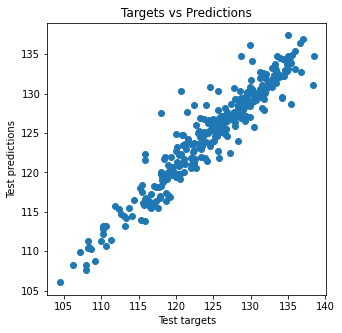

In [14]:
plt.figure(figsize=(5,5))

plt.scatter(y_test, y_test_preds)
plt.xlabel("Test targets")
plt.ylabel("Test predictions")
plt.title("Targets vs Predictions")

#### Conclusion
- Dans le cas d'un arbre de décision, on avait une MSE de ~2.60, La forêt aléatoire améliore donc le résultat!